# Анализ результатов А/В теста интернет-магазина

Вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки крупного интернет-магазина.

Также у нас есть данные о пользователях двух групп А и В, участвовавших в проведении А/В теста в течение августа 2019 г., и их заказах.

Задачи нашего исследования:

* приоритизировать гипотезы;
* проанализировать результаты А/В теста.

План нашего проекта:

1. Приоритизировать гипотезы для увеличения выручки с помощью методов ICE и RICE, сравнить полученные результаты;
2. Оценить результаты A/B-теста визуально и выяснить, есть ли в данных выбросы;
3. Удалить выбросы и найти границу для их определения;
4. Посчитать статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным и «очищенным» данным;
5. Принять решение по результатам А/В теста.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-и-предобработка-данных" data-toc-modified-id="Изучение-и-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение и предобработка данных</a></span></li><li><span><a href="#Приоритизация-гипотез" data-toc-modified-id="Приоритизация-гипотез-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Приоритизация гипотез</a></span></li><li><span><a href="#Анализ-A/B-теста" data-toc-modified-id="Анализ-A/B-теста-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ A/B-теста</a></span></li>

## Изучение и предобработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as stats

import numpy as np

In [2]:
hypothesis = pd.read_csv('datasets/hypothesis.csv')
orders = pd.read_csv('datasets/orders.csv')
visitors = pd.read_csv('datasets/visitors.csv')

**Предобработка данных hypothesis**

In [3]:
# метод позволяющий отобразить в строке 150 знаков
pd.options.display.max_colwidth = 150
hypothesis.info()
hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


В таблице содержатся информация о 9 подготовленных гипотезах для увеличения выручки:

    Hypothesis — краткое описание гипотезы;
    Reach — охват пользователей по 10-балльной шкале;
    Impact — влияние на пользователей по 10-балльной шкале;
    Confidence — уверенность в гипотезе по 10-балльной шкале;
    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале.
    
    Чем больше значение Efforts, тем дороже проверка гипотезы.

In [4]:
# Приведем названия столбцов к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()

In [5]:
# Выведем процент пропусков
round((hypothesis.isna().mean()*100),2)

hypothesis    0.0
reach         0.0
impact        0.0
confidence    0.0
efforts       0.0
dtype: float64

In [6]:
# Обработаем пропуски при необходимости
hypothesis.duplicated().sum()

0

**Предобработка данных orders**

In [7]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


В таблице содержатся информация о заказах после проведения А/В теста:

    transactionId — идентификатор заказа;
    visitorId — идентификатор пользователя, совершившего заказ;
    date — дата, когда был совершён заказ;
    revenue — выручка заказа;
    group — группа A/B-теста, в которую попал заказ.

In [8]:
# заменим названия столбцов
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})

In [9]:
# Выведем процент пропусков
round((orders.isna().mean()*100),2)

transaction_id    0.0
visitor_id        0.0
date              0.0
revenue           0.0
group             0.0
dtype: float64

In [10]:
# Обработаем пропуски при необходимости
orders.duplicated().sum()

0

In [11]:
# преобразуем данные о времени
# orders['date'] = pd.to_datetime(orders['date'])
# и выведем ещё раз информацию о таблице
# orders.info()

**Предобработка данных visitors**

In [12]:
visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


В таблице содержатся информация о пользователях, участвовавших в проведении А/В теста:

    date — дата;
    group — группа A/B-теста;
    visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [13]:
# Выведем процент пропусков
round((visitors.isna().mean()*100),2)

date        0.0
group       0.0
visitors    0.0
dtype: float64

In [14]:
# Обработаем пропуски при необходимости
visitors.duplicated().sum()

0

В столбце date таблиц orders и visitors тип не соответствует данным даты. Заменим тип данных

In [15]:
# преобразуем данные о времени
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

**Вывод**

На этапе предобработки данных мы изучили данные из файлов, привели названия столбцов таблиц к одному стилю, обработали дубликаты и заменили типы данных, где это было необходимо.

## Приоритизация гипотез

С помощью метода ICE проведем приоритизацию сформулированных гипотез.

In [16]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
round(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False),2)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


9 гипотеза - самая перспективная. За ней следуют - 1 и 8.

Теперь проведем приоритизацию гипотез с помощью метода RICE .

In [17]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
round(hypothesis.sort_values(by='RICE', ascending=False),2)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


1 гипотеза заняла одно из первых мест. Однако, метод RICE выделил больше всего 8 гипотезу, за ней - 3, 1 и 7.
Так вышло, поскольку для 8 гипотезы Reach(охват пользователей) составил максимум - 10 в отличие от других гипотез. В приоритете также оказалась 3 гипотеза, т.к. у неё тоже большой охват - 8.

**Вывод**

Метод RICE выделил больше всего 8 гипотезу, а метод ICE - 9 гипотезу.
Так вышло, поскольку для 8 гипотезы Reach(охват пользователей) составил максимум - 10 в отличие от других гипотез. 

## Анализ A/B-теста

Сначала проверим, нет ли у нас пользователей, которые попали в обе группы: А и В.

In [18]:
# определим пересечение групп
group_intersections = (orders.groupby(['visitor_id']) #группируем по айди
       .agg({'group':'nunique'}) #считаем количество групп для каждого айди
       .query('group > 1')  #выводим результат, где групп больше 1
)

# посчитаем кол-во уникальных пользователей всего
unique_visitors  = orders['visitor_id'].nunique()

print(unique_visitors)
# оценим долю  пользователей, которые попали в обе группы
percentage = group_intersections.count() / unique_visitors
round(percentage,3)

1031


group    0.056
dtype: float64

Пользователи, которые попали в обе группы: А и В, составили чуть больше 5% от всех пользователей, и вероятно появились из-за технической ошибки. Значит, их удаление не повлияет значительно на результаты теста.

In [19]:
group_a = (orders.query('group == "A"'))

group_b = (orders.query('group == "B"'))
group_intersections = list(np.intersect1d(group_a['visitor_id'], group_b['visitor_id']))

In [20]:
# Исключим данных пользователей из теста
orders = orders.query('visitor_id not in @group_intersections')
new_unique_visitors = orders['visitor_id'].nunique()
new_unique_visitors

973

После удаления у нас остались результаты о 973 пользователях.

Также изучим:

* сколько у нас групп в АВ-тесте;
* даты начала и окончания теста;
* сколько пользователей в каждой группе - по таблице с заказами.

In [21]:
# посчитаем количество групп в тесте
orders['group'].nunique()

2

In [22]:
#узнаем даты начала и окончания теста

print('Дата начала тестатаблицы orders:', orders['date'].dt.date.min())
print('Дата окончания теста таблицы orders:', orders['date'].dt.date.max())

print('Дата начала тестатаблицы visitors:', orders['date'].dt.date.min())
print('Дата окончания теста таблицы visitors:', orders['date'].dt.date.max())

Дата начала тестатаблицы orders: 2019-08-01
Дата окончания теста таблицы orders: 2019-08-31
Дата начала тестатаблицы visitors: 2019-08-01
Дата окончания теста таблицы visitors: 2019-08-31


Теперь мы знаем, что А/В тест проводился в течение одного месяца - августа 2019 г., в котором участвовали 973 пользователя.

In [23]:
# выясним, сколько пользователей в каждой группе 
group_a = (orders.query('group == "A"'))

group_b = (orders.query('group == "B"'))

print(group_a['visitor_id'].nunique(), 'доля пользователей A', group_a['visitor_id'].nunique() / new_unique_visitors)

group_b = (orders.query('group == "B"'))
print(group_b['visitor_id'].nunique(), 'доля пользователей В', group_b['visitor_id'].nunique() / new_unique_visitors)

445 доля пользователей A 0.4573484069886948
528 доля пользователей В 0.5426515930113053


**1. Построим график кумулятивной выручки по группам.**

In [24]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]


In [25]:
if (
    (cumulativeData['date'].dt.date.min() == orders['date'].dt.date.min())
    and (cumulativeData['date'].dt.date.max() == orders['date'].dt.date.max())
):
    print('успех')


успех


In [26]:
cumulativeData['date']

0    2019-08-01
1    2019-08-01
2    2019-08-02
3    2019-08-02
4    2019-08-03
        ...    
57   2019-08-29
58   2019-08-30
59   2019-08-30
60   2019-08-31
61   2019-08-31
Name: date, Length: 62, dtype: datetime64[ns]

In [27]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]


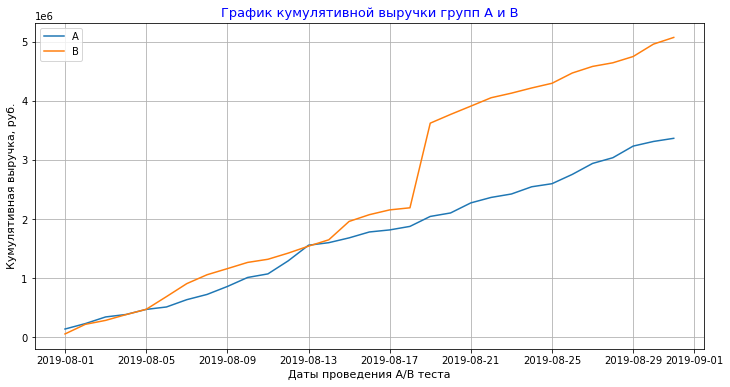

In [28]:
fig = plt.figure(figsize = (12,6))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивной выручки групп А и В', fontsize=13, color='blue')
plt.xlabel('Даты проведения А/В теста',fontsize=11)
plt.ylabel('Кумулятивная выручка, руб.',fontsize=11)
plt.legend()
plt.grid(True)
plt.show()

В начале теста кумулятивные выручки группы А и В были практически одинаковы, однако после 17 августа выручка группы В резко выросла и лидировала весь остаток теста. Причиной такого роста может быть увеличение числа заказов пользователями группы В, либо появление аномально дорогих заказов в выборке. Выясним это далее.

**2. Построим график кумулятивного среднего чека по группам.**

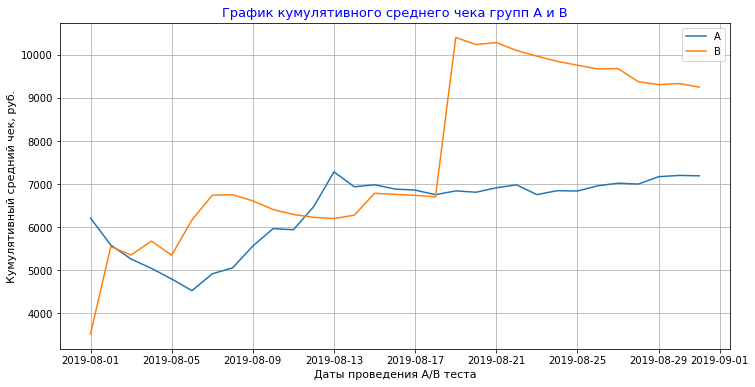

In [29]:
fig = plt.figure(figsize = (12,6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('График кумулятивного среднего чека групп А и В', fontsize=13, color='blue')
plt.xlabel('Даты проведения А/В теста',fontsize=11)
plt.ylabel('Кумулятивный средний чек, руб.',fontsize=11)
plt.legend() 
plt.grid(True)
plt.show()

Кумулятивный средний чек в обеих группах сильно колеблется. И на графике видим всплеск среднего чека заказа пользователей группы В после 17 августа 2019 г. в то же время, что и кумулятивной выручки. Это уже явный сигнал, что нужно проанализировать такой резкий рост.

**3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A.** 

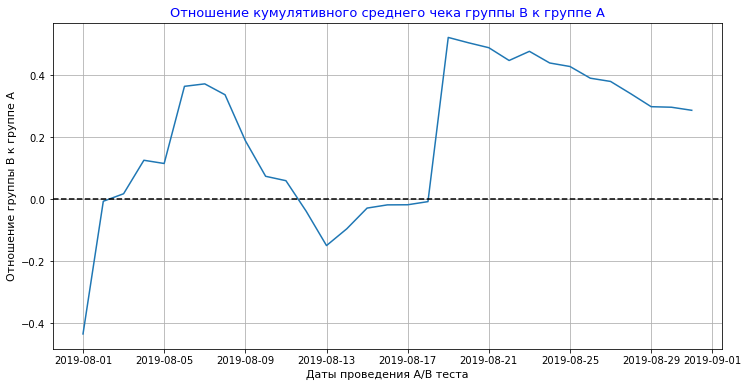

In [30]:
fig = plt.figure(figsize = (12,6))
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Отношение кумулятивного среднего чека группы В к группе А', fontsize=13, color='blue')
plt.xlabel('Даты проведения А/В теста',fontsize=11)
plt.ylabel('Отношение группы В к группе А',fontsize=11) 
plt.grid(True)
plt.show()

Отношение средних чеков группы В к группе А сильно колебалось за время проведения теста. Делать какие-либо выводы по данному графику неверно, резкие колебания возможно наблюдаются из-за аномальных покупок.

**4. Построим график кумулятивной конверсии по группам.**

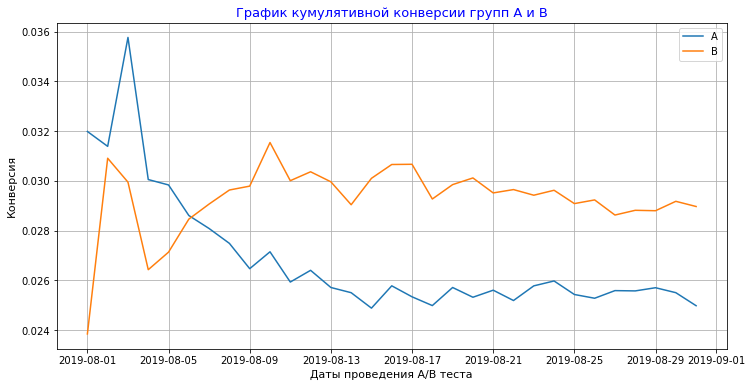

In [31]:
fig = plt.figure(figsize = (12,6))
# считаем кумулятивную конверсию
cumulativeData['conversion'] = (
    cumulativeData['orders'] / cumulativeData['visitors']
)

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивной конверсии групп А и В', fontsize=13, color='blue')
plt.xlabel('Даты проведения А/В теста',fontsize=11)
plt.ylabel('Конверсия',fontsize=11) 
plt.grid(True)
plt.legend()
plt.show()

Почти с самого начала теста конверсия группы В выше, чем конверсия группы А. Стоит также отметить сильный всплекск конверсий в начале проведения теста.

**5. Построим график относительного изменения кумулятивной конверсии группы B к группе A.**

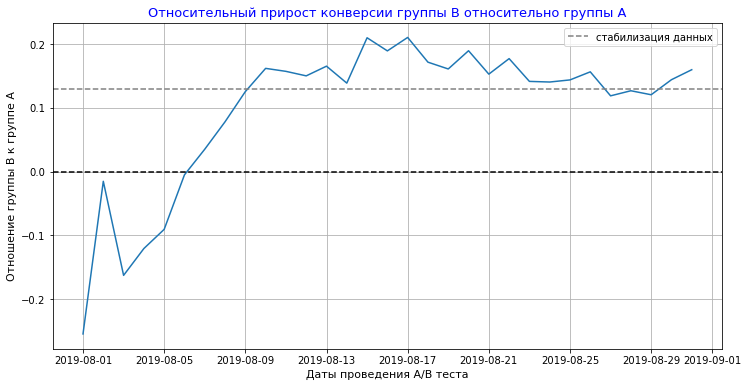

In [32]:
fig = plt.figure(figsize = (12,6))

mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y= 0.13, color='grey', linestyle='--', label='стабилизация данных')
plt.title('Относительный прирост конверсии группы B относительно группы A', fontsize=13, color='blue')
plt.xlabel('Даты проведения А/В теста',fontsize=11)
plt.ylabel('Отношение группы В к группе А',fontsize=11) 
plt.grid(True) 
plt.legend()
plt.show()

На графике видно, что у группы В рос прирост конверсии относительно группы А, но после 17 августа конверсия пошла на снижение, а после 29 августа снова растет.

Изучим данные о заказах, чтобы выявить аномалии в данных, которые могут искажать результаты теста.

**6. Построим точечный график количества заказов по пользователям.**

In [33]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['visitor_id', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


In [34]:
ordersByUsers['orders'].describe()

count    973.000000
mean       1.044193
std        0.238090
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: orders, dtype: float64

Среди пользователей есть те, кто совершал 3 заказа, хотя в среднем пользователи совершают только 1 заказ.

Построим точечный график количества заказов по пользователям.

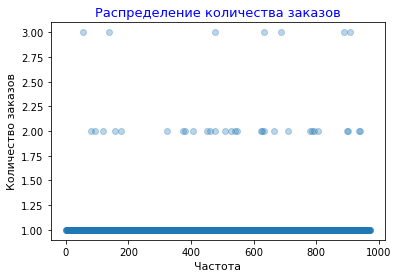

In [35]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'], alpha=0.3)
plt.title('Распределение количества заказов', fontsize=13, color='blue')
plt.xlabel('Частота',fontsize=11)
plt.ylabel('Количество заказов',fontsize=11) 
plt.show()

График подтверждает, что основная масса пользователей совершают только 1 заказ, а тех, кто покупает более 2 раз - очень мало.

Вычислим, сколько пользователей необходимо отсеить, чтобы получить корректные результаты А/В теста.

**7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.** 

In [36]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99]))

[1. 1. 2.]


Не более 5% пользователей оформляли больше 1 заказов, и только 1% 
пользователей - больше 2 заказов.

*Таким образом, лучше выбрать и отсеять аномальных пользователей с количеством заказов от 3 заказов и больше.*

**8. Построим точечный график стоимостей заказов.**

In [37]:
orders['revenue'].describe()

count    1.016000e+03
mean     8.300815e+03
std      4.212199e+04
min      5.000000e+01
25%      1.190000e+03
50%      2.955000e+03
75%      8.134250e+03
max      1.294500e+06
Name: revenue, dtype: float64

Максимальная выручка - 1 294 500 руб. при медианном значении выручки 2 955 руб. слишком сильно выделяется. Такое значение исказит результаты и сделает победителем ту группу, где оно оказалось.

Изучим гистограмму распределения стоимостей заказов:

Рассмотрим распределение выручки на точечном графике.

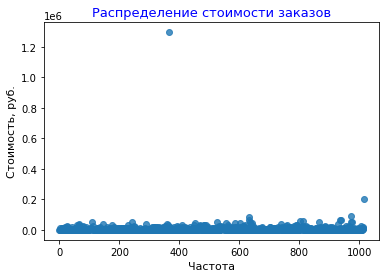

In [38]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], alpha=0.8)
plt.title('Распределение стоимости заказов', fontsize=13, color='blue')
plt.xlabel('Частота',fontsize=11)
plt.ylabel('Стоимость, руб.',fontsize=11) 
plt.show()

В диаграмме рассеяния видимо совсем немного дорогих заказов, но они могут значительно искажать результаты А/В теста.
Поскольку из-за дорогих графиков диаграмму неинформативна, посмотроим новую с ограничениями стоимости закакзов.

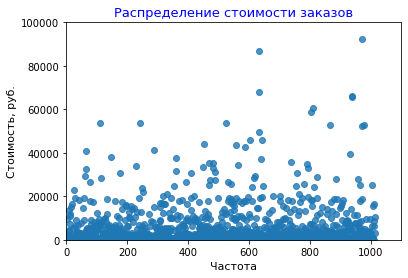

In [39]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], alpha=0.8)
plt.title('Распределение стоимости заказов', fontsize=13, color='blue')
plt.xlabel('Частота',fontsize=11)
plt.ylabel('Стоимость, руб.',fontsize=11) 
plt.axis([0, 1100, 0, 100000]) 
plt.show()

Как видно из графика, основная часть заказов оформлена на суммы до 20000-40000 руб. Рассчитаем далее конкретные цифры. 

**9. Посчитаем 95-й и 99-й перцентили стоимости заказов.**

In [40]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[17990. 26785. 53904.]


Не более 5% пользователей заказывали на сумму более 26 785 руб., и только 1 % - на сумму свыше 53 904 руб.

*Таким образом, лучше выбрать и отсеять аномальных пользователей с суммой покупки более 26 785 руб.*

**10. Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.** 

Сформулируем гипотезы. 

Нулевая: различий в конверсии между группами нет. Альтернативная: различия в конверсии между группами есть.

Рассчитаем данные, необходимые для расчета статистической значимости и соберем их в отдельную таблицу.

Проверку гипотез будем проводить с помощью теста Манна-Уитни.

Уровень статистической значимости alpha возьмем 0,05.

In [41]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


В данной таблице

    date — дата;
    ordersPerDateA — количество заказов в выбранную дату в группе A;
    revenuePerDateA — суммарная выручка в выбранную дату в группе A;
    ordersPerDateB — количество заказов в выбранную дату в группе B;
    revenuePerDateB — суммарная выручка в выбранную дату в группе B;
    ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
    revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
    ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
    revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
    visitorsPerDateA — количество пользователей в выбранную дату в группе A;
    visitorsPerDateB — количество пользователей в выбранную дату в группе B;
    visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
    visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.
    

Посчитаем статистическую значимость различия в конверсии между группами.

In [42]:
# Создадим переменные c количество совершенных пользователями заказов
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 


In [43]:
# Объявим переменные, в которых пользователям из разных групп будет соответствовать количество заказов. 
# Тем, кто ничего не заказал, будут соответствовать нули. 

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders']) # создадим список индексов
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders']) # создадим список индексов
            ),
            name='orders',
        ),
    ],
    axis=0,
)

alpha = 0.05

# Применим критерий Манна-Уитни.
results = stats.mannwhitneyu(sampleA, sampleB)

print('p-значение: ', "{0:.3f}".format(results.pvalue))

# сравним значение p-value с alpha
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

# Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1. 
print('Относительный прирост конверсии группы B - ', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-значение:  0.011
Отвергаем нулевую гипотезу: разница статистически значима
Относительный прирост конверсии группы B -  0.160


Первое число — p-value = 0.011 меньше, чем 0.05. 
*Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Разница статистически значима.* И конверсия группы B выше на 16%.

**11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.**

Сформулируем гипотезы. Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [44]:
# Применим критерий Манна-Уитни.
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

print('p-значение: ', "{0:.3f}".format(results.pvalue))

# сравним значение p-value с alpha
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

# найдём относительные различия в среднем чеке между группами:
print('Относительные различия в среднем чеке между группами- ', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-значение:  0.829
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
Относительные различия в среднем чеке между группами-  0.287


P-value гораздо больше 0.05. *Таким образом, разницы в среднем чеке нет.* И наблюдаемое различие в 29% не является значимым.

**12. Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.**

Для начала удалим аномальных пользователей.

Примем за аномальных пользователей тех, кто совершил от 3 заказов и больше или совершил заказ дороже 26 785 руб. Ранее в работе мы выделили их с помощью расчетов. Так мы уберём 1% пользователей с наибольшим числом заказов и 5% пользователей с самыми дорогими заказами. 

In [45]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))

# Узнаем, сколько всего аномальных пользователей методом shape()
print(abnormalUsers.shape[0]) 

1099    148427295
928     204675465
33      249864742
684     358944393
648     382846391
Name: visitor_id, dtype: int64
55


Всего 55 аномальных пользователя.

Узнаем, как их действия повлияли на результаты теста. 

In [46]:
# Сначала подготовим выборки количества заказов по пользователям по группам теста:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

# Применим критерий Манна-Уитни.
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)

print('p-значение: ', "{0:.3f}".format(results.pvalue))

# сравним значение p-value с alpha
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

print('Относительный прирост конверсии группы B - ','{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-значение:  0.009
Отвергаем нулевую гипотезу: разница статистически значима
Относительный прирост конверсии группы B -  0.189


Результаты p-value практически не изменились. *Нулевую гипотезу также отвергаем. Итого, разница конверсий группы В и А статистически значима.* Конверсия группы B стало немного выше: 19% против 16 % по "сырым" данным.

**13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.**

In [47]:
# Применим критерий Манна-Уитни.
results = stats.mannwhitneyu(orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )

print('p-значение: ', "{0:.3f}".format(results.pvalue))

# сравним значение p-value с alpha
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
    
print(
    'Относительные различия в среднем чеке между группами- ',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 


p-значение:  0.762
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
Относительные различия в среднем чеке между группами-  -0.022


P-value среднего чека снизился. *Таким образом, разницы в среднем чеке по "очищенным " данным тоже нет, как и по "сырым" данным.* Однако после удаления аномальных данных корректно рассчитывается относительное различие в среднем чеке между группами: оно теперь действительно минимальное. Значит, действительно выявленный дорогой заказ 1 294 500 руб. сильно повлиял на результаты теста.

**14. Примем решение по результатам теста**

Полученные в ходе А/В теста выводы:

* Разница конверсий группы В и А статистически значима между группами А и В;
* Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
* Из графика различия конверсии между группами выяснили, что результаты группы B были лучше группы A, но ближе к концу теста ухудшились;
* График различия среднего чека говорит о том, что отношение средних чеков группы В к группе А сильно колебалось за время проведения теста. Итого отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по данному графику неверно. Этот график позволил нам выяснить, что есть аномалии.

**Таким образом, группа B статистически значимо лучше группы A по результатам параметрического теста Уилкоксона-Манна-Уитни, и график конверсии также говорит о том, что показатели группы B выше. Значит, можно остановить тест, зафиксировать победу группы В.**

**Общий вывод**

В проекты были изучены данные о пользователях двух групп А и В, участвовавших в проведении А/В теста, и их заказах. На этапе предобработки данных привели названия столбцов таблиц к одному стилю, обработали дубликаты и заменили типы данных, где это было необходимо.

В рамках исследования была также проведена приоритизация подготовленных гипотез с помощью методов RICE и ICE. 
В результате метод RICE выделил больше всего 8 гипотезу, а метод ICE - 9 гипотезу. Так вышло, поскольку для 8 гипотезы Reach(охват пользователей) составил максимум - 10 в отличие от других гипотез.

В данных, полученных после проведения А/В теста, была найдена ошибка: около 5% пользователей попали в обе группы сразу: А и В. Для корректного отражения результата теста, они были удалены из выборки.

В ходе анализа результатов А/В теста  выяснили, что:

* Основная масса пользователей совершают только 1 заказ, а тех, кто покупает более 2 раз - очень мало. Средний чек заказов интернет-магазина для 95 % пользователей составил не более 26 785 руб.
* В начале теста кумулятивные выручки группы А и В были практически одинаковы, однако после 17 августа 2019 г. выручка группы В резко выросла и лидировала весь остаток теста. Кумулятивный средний чек в обеих группах сильно колебался, и на графике увидели всплеск среднего чека заказа пользователей группы В в то же время, что и всплеск кумулятивной выручки. Причиной такого роста оказались аномально дорогие заказы в выборке. 

*Для того чтобы пользователи с аномально дорогими заказами не искажали результаты теста, был принято решение исключить их из выборки. Также были найдены пользователи с аномально большим количеством заказов. В итоге процент удаленных пользователей составил менее 6% от общего числа.*

* Почти с самого начала теста кумулятивная конверсия группы В выше, чем кумулятивная конверсия группы А. К концу теста разница составила примерно 5 процентных пункта. 
* Прирост конверсии у группы В был выше относительно группы А и постепенно стабилизировался на уровне 13 %.

В результате анализ проведенного А/В теста показал, что:

1. Разница конверсий группы А и В статистически значима. Из графика различия конверсии между группами выяснили, что результаты группы B были лучше группы A , но ближе к концу теста стали немного хуже. Относительный прирост конверсии группы B оказался выше группы А и по «сырым», и по данным после фильтрации аномалий;
2. P-value среднего чека выше уровня статистической значимости  По среднему чеку наоборот нет статистически значимого различия  между группами ни по «сырым», ни по данным после фильтрации аномалий.

*Таким образом, группа B статистически значимо лучше группы A по результатам А/В теста. Значит, можно остановить тест, зафиксировать победу группы В.*